Discard: Development step for CTMNRE

In [1]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import torch

In [2]:
import swyft
import pylab as plt
import numpy as np
import scipy

In [3]:
import swyft

In [4]:
def logdiffcdf(dist, a, b):
    if dist.cdf(b) < 0.5:
        return np.log(dist.cdf(b) - dist.cdf(a))
    else:
        return np.log(dist.sf(a) - dist.sf(b))
    
def logdiffcdf(dist, a, b):
    return np.where(dist.cdf(b) < 0.5,
        np.log(dist.cdf(b) - dist.cdf(a)),
        np.log(dist.sf(a) - dist.sf(b))
            )

dist = scipy.stats.norm(0, 1)
logdiffcdf(dist, -10, 0)

array(-0.69314718)

In [5]:
def trunc_sample(dist, r, size = None, return_logdiffcdf = True):
    r = np.array(r)
    c = dist.cdf(r)
    s = scipy.stats.uniform(loc = c[...,0], scale = c[...,1] - c[...,0]).rvs(size=size)
    z = np.array(dist.ppf(s))
    if not return_logdiffcdf:
        return z
    else:
        l = logdiffcdf(dist, r[...,0], r[...,1])
        return z, l

dist = scipy.stats.lognorm(1., 0.1)
s = 0.1
trunc_sample(dist, [s, s+1], return_logdiffcdf = True)

(array(0.21030622), array(-0.69314718))

In [6]:
N = 10
def prior():
    beta = scipy.stats.lognorm(1, 0.01).rvs()
    z = scipy.stats.norm(0, beta).rvs((N,))
    return dict(beta = beta, z = z)
    
def model(pars):
    z = pars['z']
    x = scipy.stats.norm(z, 0.0001).rvs()
    return dict(x = x)

pars = prior()
model(pars)

{'x': array([ 0.25900024,  0.09748594, -0.12619322, -0.18476429,  0.30334348,
        -0.26550228,  0.04691092,  0.3183778 , -0.16335806,  0.2170522 ])}

In [7]:
def trunc_prior(truncs):
    beta, log_prob_beta = trunc_sample(scipy.stats.lognorm(1, 0, 1), truncs['beta'])
    z, log_prob_z = trunc_sample(scipy.stats.norm(0, beta), truncs['z'])
    weight = np.exp(log_prob_z.sum())
    return dict(beta = beta, z = z, weight = weight)

In [8]:
def get_trunc_draws(Ntrials, truncs):
    draws = [trunc_prior(truncs) for _ in range(Ntrials)]
    weights = np.array([v['weight'] for v in draws])
    mask = weights/weights.max() > np.random.rand(len(weights))
    return [draws[i] for i in np.arange(Ntrials)[mask]]

In [42]:
z_trunc = np.ones((100, 2))
z_trunc[:,0] = 0.4
z_trunc[:,1] = 0.5
truncs = dict(beta=[0.35, 0.55], z = z_trunc)
draws = get_trunc_draws(1000, truncs)
betas = np.array([v['beta'] for v in draws])
zs = np.array([v['z'] for v in draws])

409

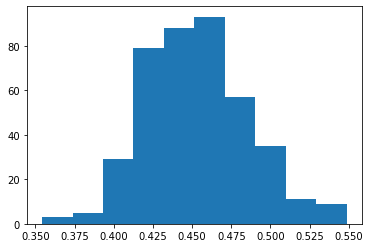

In [10]:
plt.hist(betas)
len(betas)

In [11]:
# DONE: 
# - Update bounds to return samples as vector
# - Does that have to be inside hypercube?

class EmpiricalBound(swyft.Bound):
    def __init__(self, u):
        self.u = u
        
    def sample(self, N):
        idx = np.random.choice(len(self.u), N, replace=False)
        return self.u[idx]
    
    def __call__(self, u):
        return np.ones(len(u))
    
    @property
    def volume(self):
        return 1.
    
    def state_dict(self):
        return {"tag": "EmpiricalBound"} 

In [12]:
r = torch.zeros(3, 2)
r[:,0] = 0.01
r[:,1] = 1-0.01
torch.distributions.Normal(0, 1).icdf(r)

tensor([[-2.3263,  2.3263],
        [-2.3263,  2.3263],
        [-2.3263,  2.3263]])

In [13]:
# TODO:
# - Generalize to any distribution with free loc and scale?
# - Should return bounds or interval rather than samples from bound region
# - Can directly act on data space

class DistributionRatio(torch.nn.Module):
    def __init__(self, dist, *shape):
        super().__init__()
        self.dist = dist
        self.log_prefactor = torch.nn.Parameter(torch.zeros(*shape))
        self.log_scale = torch.nn.Parameter(torch.zeros(*shape))
        
    def bounds(self, m, epsilon):
        scale = torch.exp(self.log_scale)
        r0 = torch.zeros_like(m) + epsilon
        r1 = torch.ones_like(m) - epsilon
        b0 = self.dist(m, scale).icdf(r0)
        b1 = self.dist(m, scale).icdf(r1)
        return torch.vstack([b0, b1])
    
    def forward(self, z, m, return_bounds = None):
        if return_bounds:
            return self.bounds(m, return_bounds)
        scale = torch.exp(self.log_scale)
        log_ratio = self.dist(m, scale).log_prob(z) + self.log_prefactor
        return log_ratio

In [14]:
# DONE
# - This remains painfully useful

class View:
    def __init__(self, **shapes):
        self._shapes = shapes
        self._i0 = {}
        self._i1 = {}
        
        N = 0
        for key, value in shapes.items():
            n = np.prod(value)
            self._i0[key] = N
            self._i1[key] = N + n
            N += n
        
        self._N = N
        
    def __len__(self):
        return self._N

class Viewer:
    def __init__(self, view, u):
        self._view = view
        self._u = u
        
    def __getattr__(self, key):
        ucut = self._u[..., self._view._i0[key]:self._view._i1[key]]
        if type(ucut) == np.ndarray:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])  # TODO Redunadnt
        else:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])
    
    def __setattr__(self, key, value):
        if key[:1] == '_':
            object.__setattr__(self, key, value)
        else:
            if type(value) == np.ndarray:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))  # TODO Redundant
            else:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))
            self._u[..., self._view._i0[key]:self._view._i1[key]] = value_shaped
    
    def __len__(self):
        return self._view._N
    
    def __call__(self):
        return self._u

## Model

In [15]:
N = 10 # Number of data bins
SIGMA = 0.01  # Measurement uncertainty

In [16]:
# DONE
# - Remove an transformation. We live in real space.

view = View(z = (N,), b = (1,))

def model(v):
    vv = Viewer(view, v)
    return dict(z=vv.z)
    
# Noise model
def noise(sim, v):
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['z'] + noise)

# Prior

def transform(u):
    return u
    
NPAR = N +1

## Network

In [17]:
# TODO:
# - Update to prior_truncated based on truncation bounds

def run_round(ntrain, bound = None, max_epochs = 0):
    store = swyft.MemoryStore(sim)
    store.add(ntrain, prior, bound)
    store.simulate()
    dataset = swyft.Dataset(ntrain*10000, prior, store, bound = bound, simhook = noise, check_coverage = False)
    print("Dataset size:", len(dataset))
    post = swyft.Posteriors(dataset)
    partition = range(NPAR)
    post.add(partition, device='cuda', head_args = dict(online_norm = False), tail = RatioSampler)
    post.train(partition, max_epochs = max_epochs, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
               batch_size = 64, optimizer_args = dict(lr = 0.01))
    tail = list(post._ratios.items())[0][1].tail
    bound = CrazyBound(x0, tail)
    return dict(post=post, store=store, dataset=dataset, tail=tail, bound=bound)

In [18]:
def plot_dataset(dataset):
    for i in range(200):
        plt.plot(dataset[i][0]['x'], color='0.5')
    plt.plot(x0, marker='x', color='r', lw=2)

In [19]:
def plot_tail(tail, u0 = None, i0 = 0, i1 = 10, scaled = False):
    NS = 1000
    s = tail.sample(x0.unsqueeze(0).repeat(NS, 1).cuda(), NS).detach().cpu().numpy()
    for i in range(i0, i1):
        if scaled:
            plt.scatter(s[:,-1], scipy.stats.norm(0., 1.).ppf(s[:,i]))
        else:
            plt.scatter(s[:,-1], s[:,i])
    plt.xlim([0, 1])
    if not scaled:
        plt.ylim([0, 1])
    if u0 is not None:
        plt.axvline(u0[-1])
        if scaled:
            s = scipy.stats.norm(0., 1.).ppf(u0[i0:i1])
            plt.scatter(u0[-1]*np.ones(i1-i0), s, marker='.', color='k')
        else:
            plt.scatter(u0[-1]*np.ones(i1-i0), u0[i0:i1], marker='.', color='k')

## Analysis

In [20]:
from swyft.utils.array import array_to_tensor
class SimpleDataset(torch.utils.data.Dataset):                                                                                                                                                 
    """Dataset which merely keeps track of observation and parameter data in one place"""                                                                                                      
                                                                                                                                                                                               
    def __init__(self, observations, us, vs) -> None:                                                                                                                   
        """                                                                                                                                                                                    
        Args:                                                                                                                                                                                  
            observations: dictionary of batched obserations                                                                                                                                    
            us: array or tensor of unit cube parameters                                                                                                                                        
            vs: array or tensor of natural parameters                                                                                                                                          
        """                                                                                                                                                                                    
        super().__init__()                                                                                                                                                                     
        b = us.shape[0]                                                                                                                                                                        
        assert (                                                                                                                                                                               
            vs.shape[0] == b                                                                                                                                                                   
        ), "the us and vs arrays do not have the same batch dimension"                                                                                                                         
        assert all(                                                                                                                                                                            
            [b == x.shape[0] for x in observations.values()]                                                                                                                                   
        ), "the observation values do not have the same batch dimension as us and vs"                                                                                                          
        self.observations = observations                                                                                                                                                       
        self.us = us                                                                                                                                                                           
        self.vs = vs                                                                                                                                                                           
        self._len = b           
        
    def pnames(self):
        return None
    
    def prior(self):
        return None
    
    def bound(self):
        return None
    
    @property
    def requires_sim(self):
        return False
                                                                                                                                                                                               
    def __getitem__(self, idx):
        return (                                                                                                                                                                               
            {                                                                                                                                                                                  
                key: array_to_tensor(val[idx, ...])                                                                                                                                            
                for key, val in self.observations.items()                                                                                                                                      
            },                                                                                                                                                                                 
            array_to_tensor(self.us[idx, ...]),                                                                                                                                                
            array_to_tensor(self.vs[idx, ...]),                                                                                                                                                
        )                                                                                                                                                                                      
                                                                                                                                                                                               
    def __len__(self) -> int:                                                                                                                                                                  
        return self._len

In [21]:
prior()
s = np.zeros((1000, NPAR))
vu = Viewer(view, s)
for i in range(len(s)):
    p = prior()
    vu.b[i] = p['beta']
    vu.z[i] = p['z']

In [22]:
us = vs = s
observations = {"x": np.array([noise(model(s[i]), s[i])['x'] for i in range(len(s))])}
dataset = SimpleDataset(observations, us, vs)

In [23]:
post = swyft.Posteriors(dataset)

In [24]:
# DONE:
# - Remove all correlation nonsense
# - Return one ratio estimator for one observable
# - Functionality to return bounds instead - not samples

class RatioSampler(swyft.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rb = DistributionRatio(torch.distributions.LogNormal, (1,))
        self.rz = DistributionRatio(torch.distributions.Normal, (N,))
        self.get_mb = torch.nn.Sequential(
            torch.nn.Linear(N, 32),
            #torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 256),
            #torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            #torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )
        self.get_mz = torch.nn.Sequential(
            #swyft.networks.linear.LinearWithChannel(N, 1, 1),
            torch.nn.Linear(1, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
            #torch.nn.ReLU(),
            #swyft.networks.linear.LinearWithChannel(N, 32, 1),
            #torch.nn.Sigmoid()  # stay within [0, 1]
        )
        self.bn = torch.nn.BatchNorm1d(N, momentum = 0.01, affine = False, eps = 1.)
    
    def embedding(self, x):
        return x

    def forward(self, x, u, return_bounds = None):
        uv = Viewer(view, u)
        
        f = self.embedding(x)
        f_sorted = torch.sort(f, dim=-1)[0]
        f_sorted = self.bn(f_sorted)
        
        mb = self.get_mb(f_sorted)
        rb = self.rb(uv.b, mb, return_bounds = return_bounds)
        
        mz = self.get_mz(f.unsqueeze(-1)).squeeze(-1)
        rz = self.rz(uv.z, mz, return_bounds = return_bounds)
        
        r = torch.hstack([rz, rb])
        return r

In [25]:
partition = range(NPAR)
post.add(partition, device='cuda', head_args = dict(online_norm = False), tail = RatioSampler)

In [26]:
post.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 64, optimizer_args = dict(lr = 0.01))

Training: lr=0.0013, Epoch=60, VL=5.685, TL=8.518


In [27]:
tail = list(post._ratios.items())[0][1].tail

In [118]:
x0, u0, _ = dataset[15:16]
x0 = x0['x'].cuda()
u0 = u0.cuda()
b = tail.forward(x0, u0, return_bounds = 0.00001)
u0[-1][-1]

tensor(0.2565, device='cuda:0')

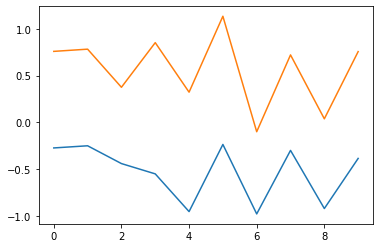

In [119]:
z_trunc = b[:, :N].cpu().detach().numpy().T
plt.plot(z_trunc[:,0])
plt.plot(z_trunc[:,1])

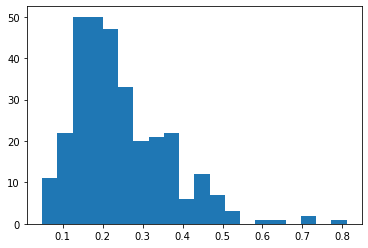

In [120]:
trunc = dict(beta = [0.01, 10.55], z = z_trunc)
draws = get_trunc_draws(3000, trunc)
len(draws)
betas = np.array([v['beta'] for v in draws])
plt.hist(betas, bins = 20);